# HSCT survival: uncensored linear regression model

## Notebook set-up

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

import functions.helper as helper_funcs

training_features_df_file='./data/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file='./data/processed/02.1-scaled_encoded_training_labels_df.parquet'

model_file='./models/03.4-uncensored_linear_regression.pkl'

## 1. Load data

In [2]:
features_df=pd.read_parquet(training_features_df_file)
labels_df=pd.read_parquet(training_labels_df_file)

df=pd.concat([features_df.reset_index(drop=True),labels_df.reset_index(drop=True)],axis=1)

raw_training_df=pd.read_csv('./data/raw/train.csv')
df['race_group']=raw_training_df['race_group']

## 2. Train-test split

In [3]:
training, testing=train_test_split(df, test_size=0.33,random_state=315)

training_df=pd.DataFrame(training, columns=df.columns)
testing_df=pd.DataFrame(testing, columns=df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

## 3. Baseline model: censored and uncensored data

In [4]:
# Instantiate default linear regression model
model=LinearRegression()

# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(
    model,
    training_features_df.drop(['ID','race_group'], axis=1),
    training_labels_df['efs_time']
)

cross_val_scores={'Baseline model': scores}

Cross validation RMSE 0.92 +/- 0.01


In [5]:
baseline_model=LinearRegression()

baseline_result=baseline_model.fit(
    training_features_df.drop(['ID','race_group'], axis=1),
    training_labels_df['efs_time']
)

## 4. Uncensored only model

### 4.1. Split data into censored and uncensored

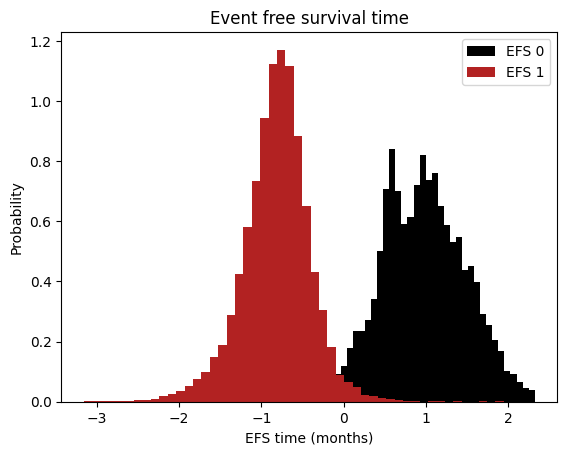

In [6]:
working_training_df=pd.concat(
    [
        training_features_df.reset_index(drop=True),
        training_labels_df.reset_index(drop=True)
    ],
    axis=1
)

censored_training_df=working_training_df[working_training_df['efs'] == 0]
uncensored_training_df=working_training_df[working_training_df['efs'] == 1]

plt.title('Event free survival time')
plt.hist(censored_training_df['efs_time'], density=True, bins=50, color='black', label='EFS 0')
plt.hist(uncensored_training_df['efs_time'], density=True, bins=50, color='firebrick', label='EFS 1')
plt.xlabel('EFS time (months)')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()

### 4.3. Linear regression model

In [7]:
uncensored_training_labels_df=uncensored_training_df[['efs', 'efs_time']]
uncensored_training_features_df=uncensored_training_df.drop(['efs', 'efs_time'], axis=1)

# Instantiate default linear regression model
model=LinearRegression()

# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(
    model,
    uncensored_training_features_df.drop(['ID','race_group'], axis=1),
    uncensored_training_labels_df['efs_time']
)

cross_val_scores['Uncensored model']=scores

Cross validation RMSE 0.37 +/- 0.01


In [8]:
uncensored_model=LinearRegression()

uncensored_result=uncensored_model.fit(
    uncensored_training_features_df.drop(['ID','race_group'], axis=1),
    uncensored_training_labels_df['efs_time']
)

with open(model_file, 'wb') as output_file:
    pickle.dump(uncensored_model, output_file)

## 5. Model comparison

### 5.1. EFS time RMSE

In [9]:
baseline_predictions=baseline_model.predict(testing_features_df.drop(['ID','race_group'], axis=1))
uncensored_predictions=uncensored_model.predict(testing_features_df.drop(['ID','race_group'], axis=1))

print(f'Baseline testing RMSE: {root_mean_squared_error(testing_labels_df["efs_time"], baseline_predictions)}')
print(f'Uncensored testing RMSE: {root_mean_squared_error(testing_labels_df["efs_time"], uncensored_predictions)}')

Baseline testing RMSE: 0.9133610272901422
Uncensored testing RMSE: 1.2928808900852846


### 5.2. Concordance index

In [10]:
baseline_cindex=concordance_index(
    testing_labels_df['efs_time'],
    baseline_predictions,
    testing_labels_df['efs']
)

uncensored_cindex=concordance_index(
    testing_labels_df['efs_time'],
    uncensored_predictions,
    testing_labels_df['efs']
)

print(f'Baseline C-index: {baseline_cindex}')
print(f'Uncensored C-index: {uncensored_cindex}')

Baseline C-index: 0.657632640957935
Uncensored C-index: 0.5498769539247942


### 5.3. Stratified concordance index

In [11]:
baseline_submission=pd.DataFrame({'ID': testing_df['ID'], 'prediction': baseline_predictions})
uncensored_submission=pd.DataFrame({'ID': testing_df['ID'], 'prediction': uncensored_predictions})
baseline_score=helper_funcs.competition_score(testing_df, baseline_submission)
uncensored_score=helper_funcs.competition_score(testing_df, uncensored_submission)

print(f'Baseline stratified concordance score: {baseline_score}')
print(f'Uncensored stratified concordance score: {uncensored_score}')

Baseline stratified concordance score: 0.33410822621538594
Uncensored stratified concordance score: 0.4282544471154018
